# Exploratory Data Analysis

In this notebook we do an in-depth EDA for the dataset.


In [1]:
import pandas as pd

import mplcairo
import matplotlib as mpl
mpl.use("module://mplcairo.qt")
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
from wordcloud import WordCloud, ImageColorGenerator

from collections import Counter
from collections import defaultdict

from utils import *

%matplotlib inline

# Data Cleaning

In [2]:
df = pd.read_csv("./data/silver_data.csv", )
df.head()

tweet sentiment
0  شەڕەفوو کەرامەتی ئەم ئاڵایە و ئەم گەل تان برد ...  positive
1  ڕۆحیان شاد ،خودای گە ورە سە بووری خانە وادە کا...  positive
2       سلاوی خودا لەتۆش بێت خودا خۆشیت بێنێتە ڕێگات  positive
3  زۆر خۆشحاڵ ئەبین کاک سیا بەڵێ بە کوردی قسە ئەکرێت  positive
4  ناوێرم یەک تویت بکەم بەدڵی خۆم خوشکەکانم ڕێک د...  positive

In [3]:

df['sentiment_encoded'] = df['sentiment'].replace({'positive': 1, 'negative': -1, 'neutral': 0})

In [4]:
df.head()

tweet sentiment  \
0  شەڕەفوو کەرامەتی ئەم ئاڵایە و ئەم گەل تان برد ...  positive   
1  ڕۆحیان شاد ،خودای گە ورە سە بووری خانە وادە کا...  positive   
2       سلاوی خودا لەتۆش بێت خودا خۆشیت بێنێتە ڕێگات  positive   
3  زۆر خۆشحاڵ ئەبین کاک سیا بەڵێ بە کوردی قسە ئەکرێت  positive   
4  ناوێرم یەک تویت بکەم بەدڵی خۆم خوشکەکانم ڕێک د...  positive   

   sentiment_encoded  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [5]:
df_emoji = pd.read_csv("./data/emoji_translation.csv")
df_emoji.columns = ['emoji', 'english', 'kurdish']
print("Count the number of translated Emojis into Kurdish:")
df_emoji.count()

Count the number of translated Emojis into Kurdish:


emoji      3569
english    3569
kurdish    1199
dtype: int64

In [6]:
# df_emoji.dropna(inplace=True)
# emoji_to_kurdi = dict(zip(df_emoji.emoji, df_emoji.kurdish))
# df['tweet'] = df['tweet'].replace(emoji_to_kurdi, regex=True)

In [7]:
df['cleaned_text'] = df['tweet'].apply(lambda x:clean_text(x, lemma=False, emoji=True))

/usr/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## Check for null values

In [8]:
df.isnull().sum()

tweet                0
sentiment            0
sentiment_encoded    0
cleaned_text         0
dtype: int64

In [9]:
df['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

## Group by different sentiments

In [10]:
# count none sentiments
df.groupby("sentiment").count()['tweet']

sentiment
negative    1500
neutral     1500
positive    1500
Name: tweet, dtype: int64

In [11]:
df.describe()

sentiment_encoded
count        4500.000000
mean            0.000000
std             0.816587
min            -1.000000
25%            -1.000000
50%             0.000000
75%             1.000000
max             1.000000

# Exploratory Data Analysis

## Sentiment Distribution

In [12]:
temp = df.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='PuBu')

<AxesSubplot:xlabel='sentiment', ylabel='count'>

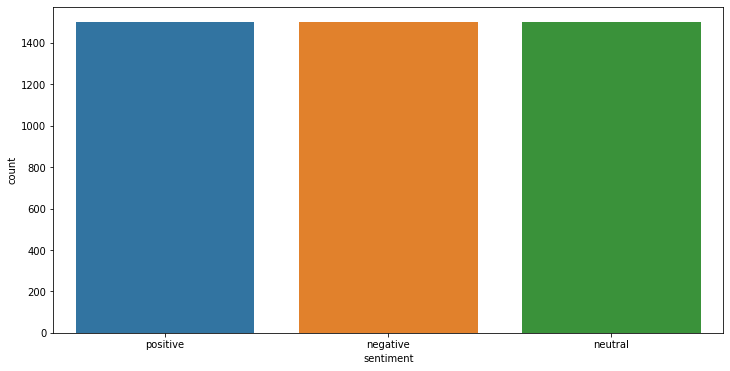

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)


In [23]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.write_image("./figures/aa_funnel_chart.pdf")
fig.show()

## Most Common Words

### Most common words of the entire dataset

In [24]:
df['temp_list'] = df['cleaned_text'].apply(lambda x:str(x).split() )
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['common_words','count']
temp.style.background_gradient(cmap='Blues')

In [25]:
fig = px.bar(temp, x="count", y="common_words", title='Commmon Words in Tweet', orientation='h', 
             width=700, height=700,color='common_words')
fig.show()

In [26]:
fig = px.treemap(temp, path=['common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### Most Common Words Sentiment Wise

In [27]:
positive_sent = df[df['sentiment']=='positive']
negative_sent = df[df['sentiment']=='negative']
neutral_sent = df[df['sentiment']=='neutral']
mixed_sent = df[df['sentiment']=='mixed']
none_sent = df[df['sentiment']=='none']

#### Most common positive words

In [28]:
top = Counter([item for sublist in positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

#### Most common negative words

In [29]:
top = Counter([item for sublist in negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(10))
temp_negative.columns = ['common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

#### Most common neutral words

In [30]:
top = Counter([item for sublist in neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(10))
temp_neutral.columns = ['common_words','count']
temp_neutral.style.background_gradient(cmap='Greys')

#### Most common none sentiment words (aka objective word)

In [31]:
raw_text = [word for word_list in df['temp_list'] for word in word_list]

def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in df[df.sentiment != sentiment]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df[df.sentiment == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    return Unique_words

#### Unique Positive Words

In [32]:
unique_positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
unique_positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


#### Unique Negative Words

In [33]:
unique_negative= words_unique('negative', 20, raw_text)
print("The top 20 unique words in Negative Tweets are:")
unique_negative.style.background_gradient(cmap='Reds')

The top 20 unique words in Negative Tweets are:


#### Unique Neutral Words

In [34]:
unique_neutral= words_unique('neutral', 20, raw_text)
print("The top 20 unique words in Neutral Tweets are:")
unique_neutral.style.background_gradient(cmap='RdPu')

The top 20 unique words in Neutral Tweets are:


In [35]:
unique_neutral= words_unique('mixed', 20, raw_text)
print("The top 20 unique words in Negative Tweets are:")
unique_neutral.style.background_gradient(cmap='Greys')

The top 20 unique words in Negative Tweets are:


## Words Clouds

In [44]:
font_file = "/home/razhan/.local/share/fonts/KHejar.ttf"

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,20), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(preprocessor_ckb.stopwords)
    more_stopwords = ['u200c', "u200d"]
    stopwords =  preprocessor_ckb.stopwords + more_stopwords
    
    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
#                     max_font_size = max_font_size, 
                    random_state = 42,
                          width=1200, height=600,
                    mask = mask,
                    font_path=font_file)
    wordcloud.generate(str(text))
    wordcloud.to_file("./figures/wordcloud.pdf")
    plt.figure(figsize=figure_size)
    
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

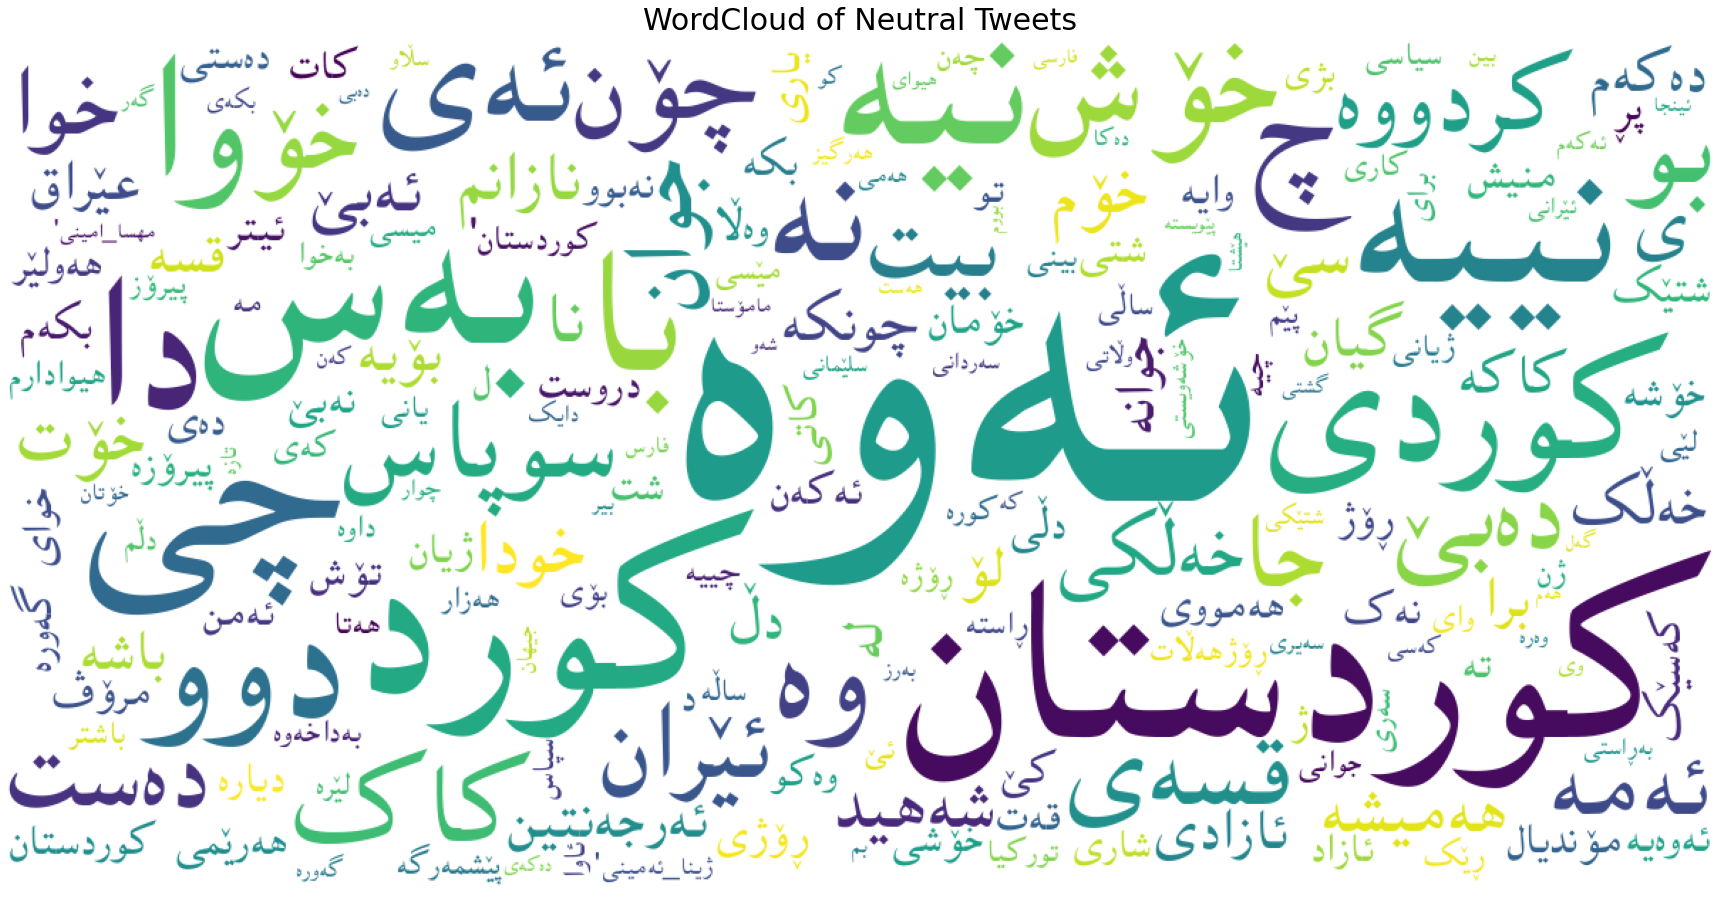

In [46]:
plot_wordcloud(neutral_sent.tweet.to_list() + positive_sent.tweet.to_list() + negative_sent.tweet.to_list(),color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

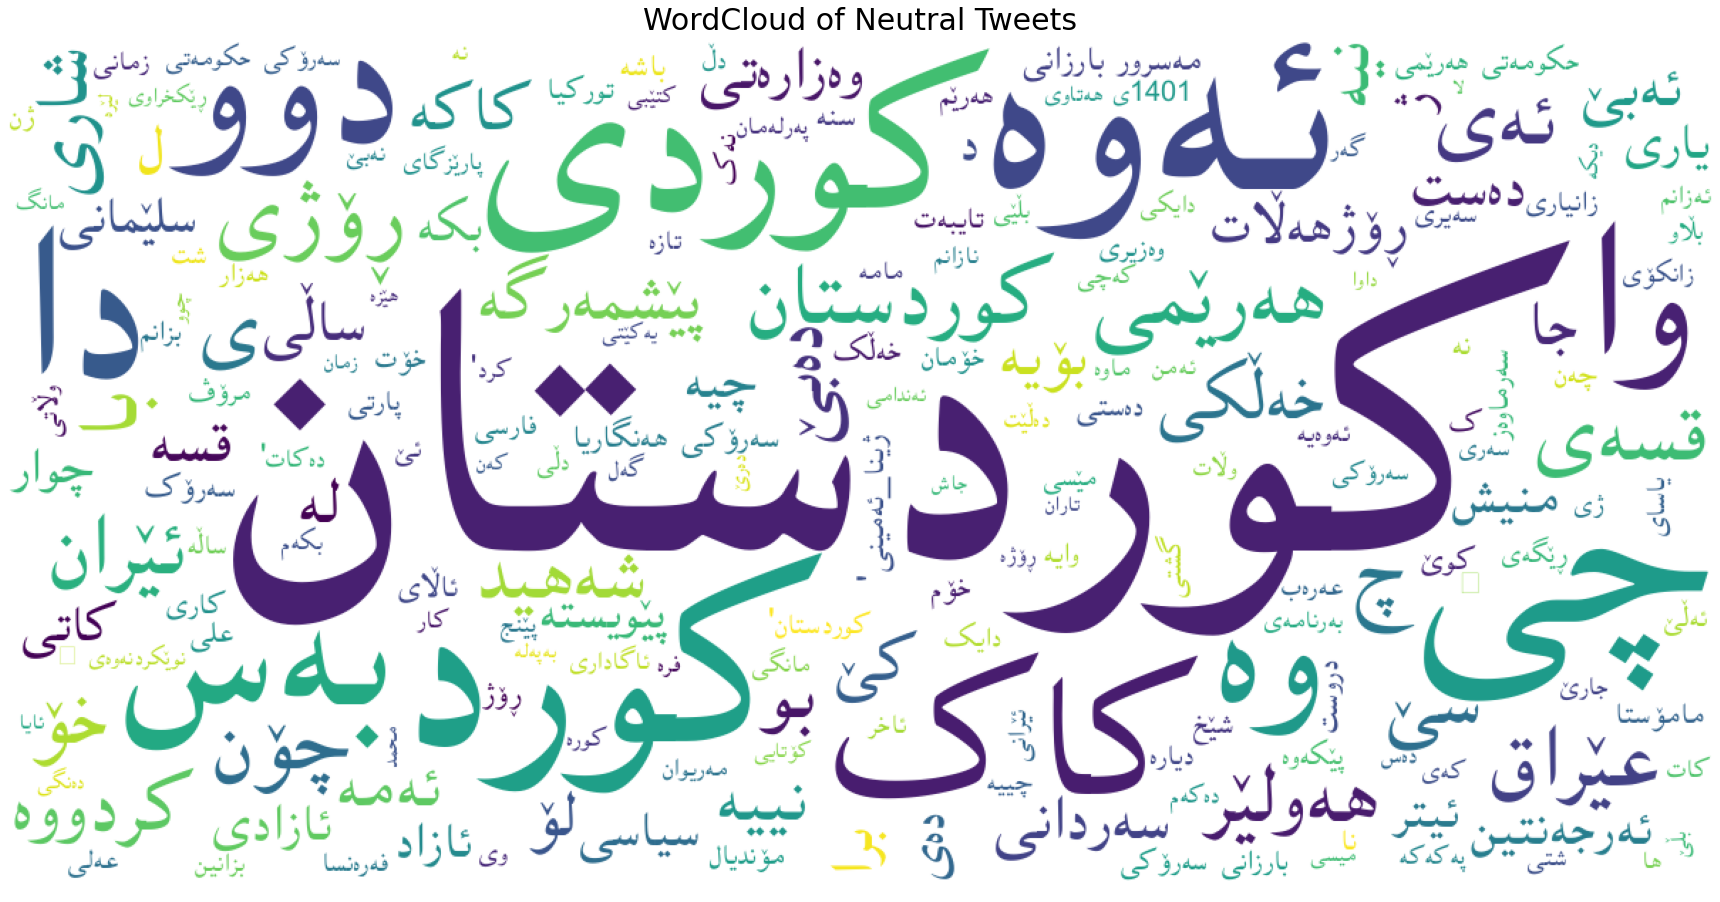

In [45]:
plot_wordcloud(neutral_sent.tweet.to_list(),color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

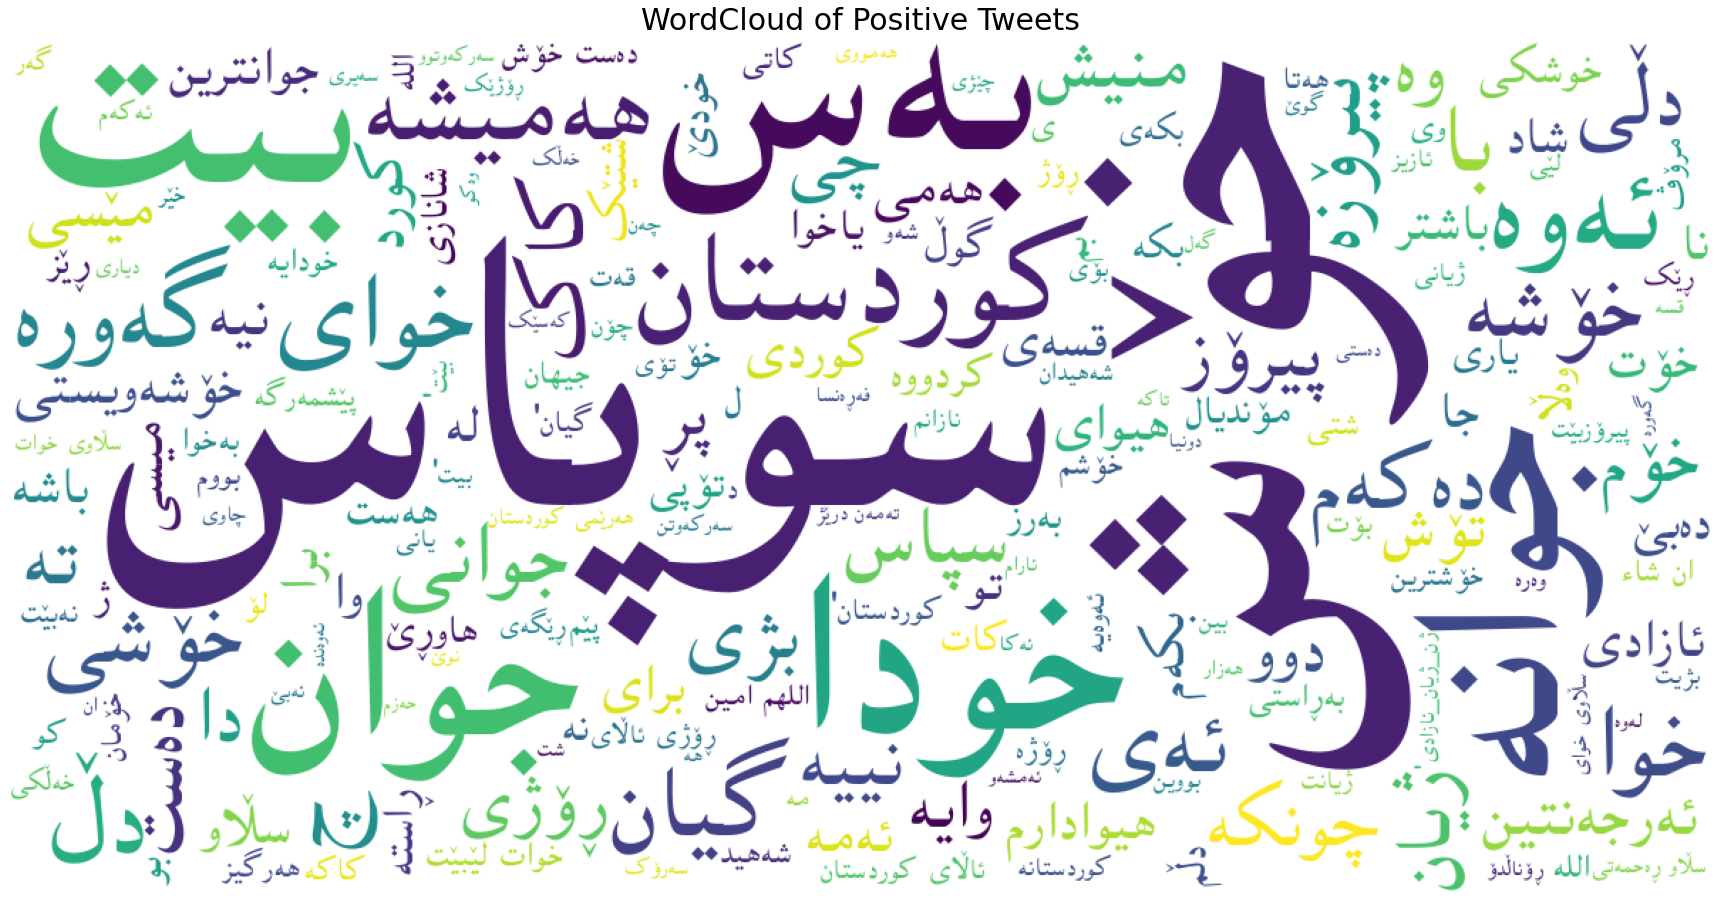

In [61]:
plot_wordcloud(positive_sent.tweet.to_list(),color='white',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

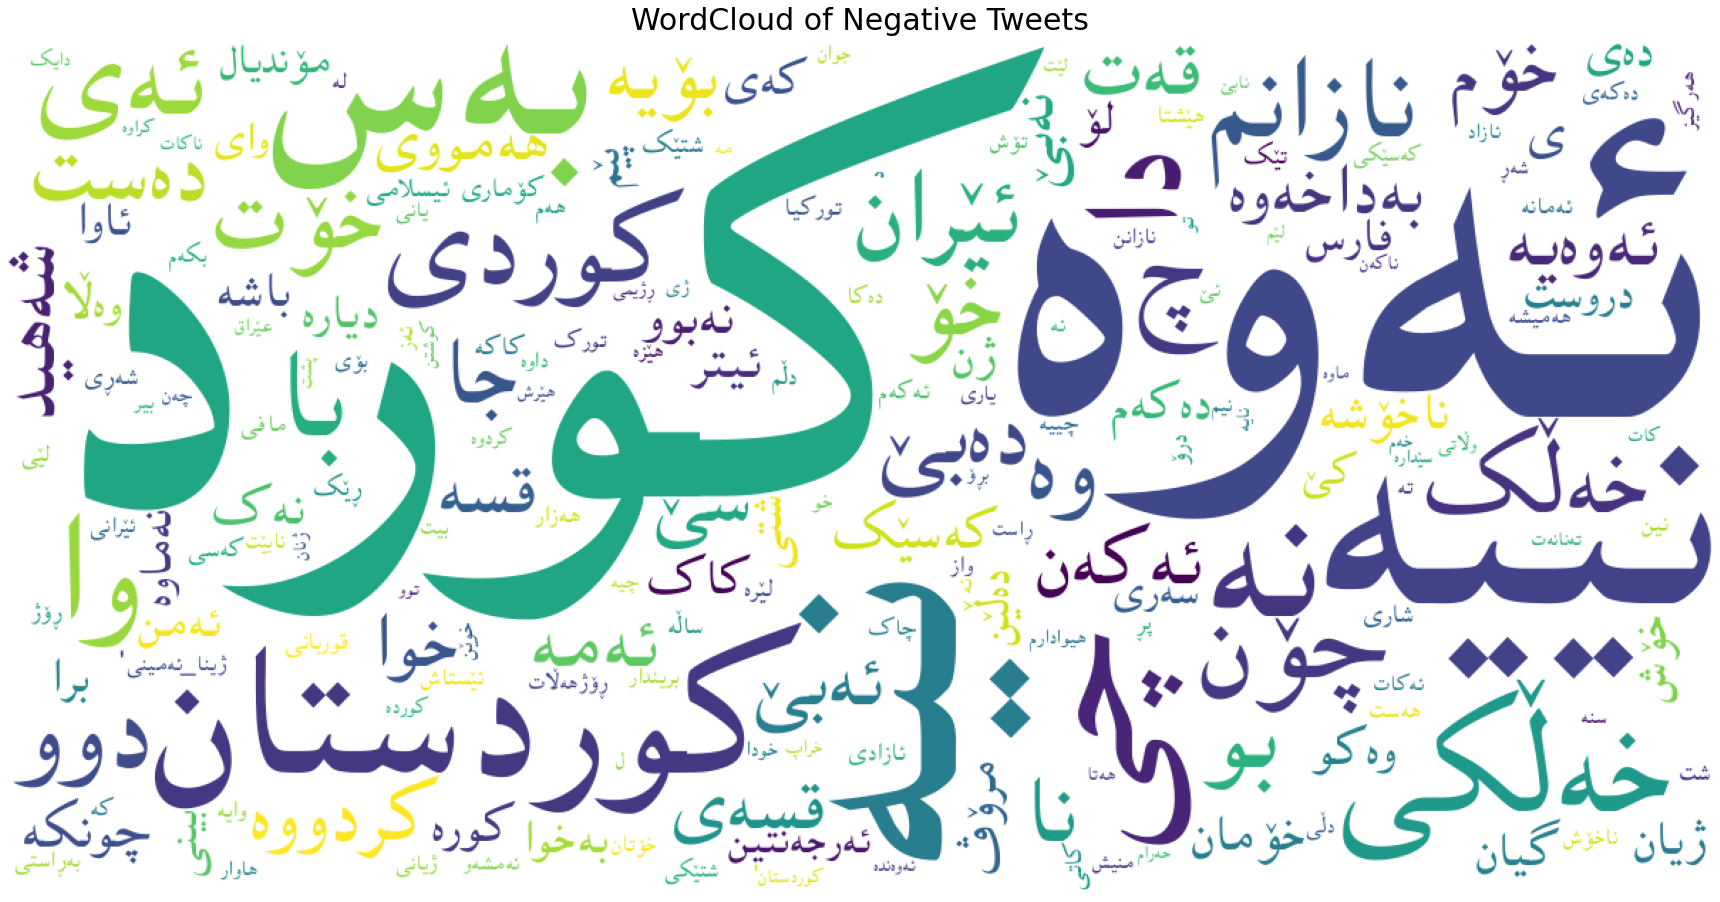

In [62]:
plot_wordcloud(negative_sent.tweet.to_list(),color='white',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

# Topic Modeling

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words=preprocessor_ckb.stopwords,
                        max_df=.1,
                        max_features=5000)
X = count.fit_transform(df['cleaned_text'].values)


In [64]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, # 10 topics
                                random_state=123,
                                learning_method='batch')
X_topics = lda.fit_transform(X)

In [65]:
lda.components_.shape

(10, 5000)

In [66]:
n_top_words = 5
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {(topic_idx + 1)}:')
    print(' '.join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
کوردستان هەرێمی لۆ بارزانی سەرۆکی
Topic 2:
کوردستان ڕۆژی ئاڵای گیان ئێران
Topic 3:
ئەی سوپاس خۆش بەس جوان
Topic 4:
بیت خۆش گەورە خوای ان
Topic 5:
ئەرجەنتین وا نیە بەس خۆ
Topic 6:
ژیان ئازادی ژن کورد کوردستان
Topic 7:
کوردستان کورد ژینا جا نازانم
Topic 8:
بەس نە ئەوە ئینستاگرام دا
Topic 9:
بو کاک کوردستان هەم با
Topic 10:
نییە کورد جوانە ئەوە بەس


Topic 3 seems to be about positivity.

Topic 10 seems to be neutral topic since the word corona appeared in the unique words of objective tweets

Let's print tweets belong to topic 10 

In [67]:
tweets = X_topics[:, 2].argsort()[::-1]

for iter_idx, tweet_idx in enumerate(tweets[:5]):
    print(f'\nTweet #{(iter_idx + 1)}:')
    print(df['cleaned_text'][tweet_idx][:300], '...')


Tweet #1:
ئەمە دوو هۆی سەرەکی هەیە 1 بە داخەوە بزووتنەوەی کوردی تاکوو ئێستاش نەیتوانیوە بە دەسەڵات بگا و خەڵکی کوردستانیش ئەو بیر و ڕا جیاوازانە بە کردەوە ببینن 2 هەر ئەمە وای کردووە کە ئەم بزووتنەوە جیاوازانە بەس لە دەلاقەی نەتەوایەتیەوە سەیر بکرێ هەرچەن تا ڕادەیێکی زۆر درووستە ...

Tweet #2:
بەعزێک لە خۆشەویستان هەن دەبینم دێن قسەی زۆر زۆر ناحەز بەفارسی دەنووسن ئای فارس وابوو ئەی تورک وابوو کاکی من ڕەخنەیان لێ بگرن ئەمیش ڕەخنەی دەگرم بۆچی ئەوکارەی ئەمە کردمان ئەوان نەیان کرد وەلی بەڕاستی ئابڕومان مەبن بەوقسانە تکایە بڕێک بەجوانی ڕەخنە بگرن مهسا امینی ...

Tweet #3:
ئاماری 10 ڕۆژ هێرشەکانی تورکیا دژی ڕۆژئاوا لە بۆردوومانی خوێندنگایەک و 3 نەخۆشخانە 13 مەدەنی و 20 گریلا شەهید بوون لە هێرشی شار و گوندەکان 13 هاوڵاتی و 19 گریلا شەهید و 22 کەس بریندار بوون 235 قوتابخانە داخراون و 21 هەزار خوێندکار لە خوێندن بێبەش بوون س قەندیل پرێس ...

Tweet #4:
6 ئەمە بابەتی وشیاری نەتەوەیی و کوردستانی بوونە ئاستی خوێندن لە نێو لوڕەکان زۆر کەمە هەر بۆیە بە ئاسانی دەکەونە ناو تەڵەی فەرسەکانەوە کۆمەڵگای ل

# References

   - https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model
   - https://www.kaggle.com/code/ngyptr/multi-class-classification-with-lstm
   - https://www.dataknowsall.com/multiclass.html
